# Group objects that behave in a similar way
### Assets that behave/trade in a similar way
- Volitility
- Price Return Behavior

In [ ]:
# Silence Warnings
import warnings 
warnings.simplefilter(action="ignore" , category=FutureWarning)

In [69]:
# Fetch/Structure Data
import numpy as np 
import pandas as pd
import yfinance as yf
import pandas_datareader.nasdaq_trader as pdr


# Feature Engineering
from sklearn.preprocessing import  StandardScaler

# Machine Learning
from sklearn.cluster import  KMeans
from sklearn import metrics

# The knee point is the point of maximum curvature.
from kneed import KneeLocator

# Co-Integration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data Extraction

In [70]:
# Data Storage
filename = "data-storage/raw_data_etf.csv"
filename_co_integration = "data-storage/raw_data_conint_pairs.csv"

In [71]:
# Load Saved Data or Fetch
load_existing = True
load_coint_pairs = True

In [72]:
# Time Range
start_date = "2023-01-01"
end_date = "2023-06-17"

### Fetch Data

In [73]:
#  Get New Data
if not load_existing:
    symbols = pdr.get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True)  &  (symbols["Market Category"] == "G")] #global markets
    symbols = list(symbols.index.values)
    
    # # create dataframe with all etf stocks data
    fetched_stocks = []
    for symbol in symbols:
        data = yf.download(symbol ,  start_date , end_date )
        data = data[["Open" , "High" , "Low" , "Close" ]].copy()
        data["Symbol"] = symbol
        fetched_stocks.append(data)
    
    # Save Data
    df = pd.concat(fetched_stocks)
    df.reset_index(inplace=True)
    df = df.pivot(index='Date', columns='Symbol', values='Close')
    df.to_csv(filename)




# READ FILE
else:
    df = pd.read_csv(filename)

# Condition Data

In [74]:

# Drop Null Values
if df.isnull().values.any():
    df = df.dropna(axis=1)
    df = df.set_index("Date")

print("Shape: " , df.shape)
df.head()

Shape:  (866, 343)


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIQ,AIRR,ALTY,...,VWOB,VXUS,VYMI,WBND,WCLD,WINC,WIZ,WOOD,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,54.860001,74.910004,80.070000,49.720001,23.665001,48.119999,67.459999,18.298000,28.822001,14.799,...,81.510002,56.310001,64.699997,94.771927,26.111000,25.834999,27.160000,66.820000,43.259998,33.209999
2020-01-03,54.570000,73.720001,79.379997,49.080002,23.555000,48.130001,66.209999,18.190001,29.115000,14.830,...,81.320000,55.619999,63.779999,94.912277,26.120001,25.834999,27.100000,66.269997,42.750000,32.930000
2020-01-06,54.349998,73.419998,79.559998,49.200001,23.565001,48.119999,66.230003,18.230000,29.013000,14.870,...,81.190002,55.700001,63.900002,94.912277,26.586000,25.879999,26.980000,66.150002,42.810001,32.856998
2020-01-07,54.430000,73.680000,79.360001,49.099998,23.650999,48.119999,66.430000,18.340000,28.969999,14.870,...,81.320000,55.599998,63.720001,94.666664,26.620001,25.879999,27.115000,66.120003,42.939999,32.759998
2020-01-08,54.480000,73.839996,79.750000,49.230000,23.763000,48.119999,66.830002,18.430000,28.945000,14.850,...,81.580002,55.700001,63.790001,94.701752,26.941000,25.879999,27.200001,66.120003,43.230000,32.939999


# Feature Engineering
- For Each ETF stock
    - average returns
    - average volitility


In [75]:
# Create Dataframe with Returns and Volitility for each stock

df_returns = pd.DataFrame(df.pct_change().mean() * 255 , columns=["Returns"])
df_returns["Volitility"] = df.pct_change().std() * np.sqrt(255)


df_returns

,Returns,Volitility
AADR,0.004054,0.270357
AAXJ,-0.001299,0.246897
ACWI,0.072782,0.229947
ACWX,0.020862,0.227489
AGNG,0.068536,0.209420
...,...,...
WINC,-0.027021,0.064515
WIZ,0.034050,0.221509
WOOD,0.063746,0.293513
XT,0.100530,0.258418


### Scaling Dataframe
- To make sure if one column ranges from 1 to 10 and another column ranges from 1000 to 10000

In [76]:
# Scaling Features
scaler = StandardScaler()

# Transform Values to propper scale size
scaler = scaler.fit_transform(df_returns)

# make a new dataframe using the scaled values
scaled_data = pd.DataFrame(scaler , columns=df_returns.columns , index=df_returns.index)
df_scaled = scaled_data


df_scaled

,Returns,Volitility
AADR,-0.387812,0.218875
AAXJ,-0.444363,0.020691
ACWI,0.338223,-0.122491
ACWX,-0.210261,-0.143257
AGNG,0.293370,-0.295897
...,...,...
WINC,-0.716086,-1.520005
WIZ,-0.070943,-0.193777
WOOD,0.242765,0.414491
XT,0.631349,0.118019


# K MEANS CLUSTERING

### Obtain Optimal Amount of Clusters
- how many clusters until the inertia dramatically decreases?

In [77]:
# Make a copy of your scaled dataframe
x = df_scaled.copy()

# Define amount of clusters
k = range(1,16,1)

# Create an empty list where we'll store the sum of squared distances
# (known as inertia) for each number of clusters
distortions = []

# Loop through each number of clusters in our range
for calc in k:
    # Create a KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=calc)
    
    # Fit the KMeans model to our data
    kmeans.fit(x)
    
    # Calculate the model's inertia (sum of squared distances to closest cluster)
    distortions.append(kmeans.inertia_)

# Use the KneeLocator function to find the "elbow point" in our range of clusters
# The elbow point is the number of clusters at which adding more clusters 
# does not significantly decrease the inertia (sum of squared distances).
# In this case, the function is looking for a point where the curve of the 
# distortions plot is convex and decreasing.
k1 = KneeLocator(k , distortions , curve="convex" , direction="decreasing")

# The elbow point (optimum number of clusters) is stored in `c`
Optimal_Amount_Clusters = k1.elbow

# Print out the optimum number of clusters
print("Optimum Clusters" , Optimal_Amount_Clusters)


Optimum Clusters 5


### Fit AI knn Model

In [78]:
# fit
k_means = KMeans(n_clusters=Optimal_Amount_Clusters)
k_means.fit(x)

KMeans(n_clusters=5)

In [79]:
# predict
prediction = k_means.predict(df_scaled)

# Display Results

<function matplotlib.pyplot.show(close=None, block=None)>

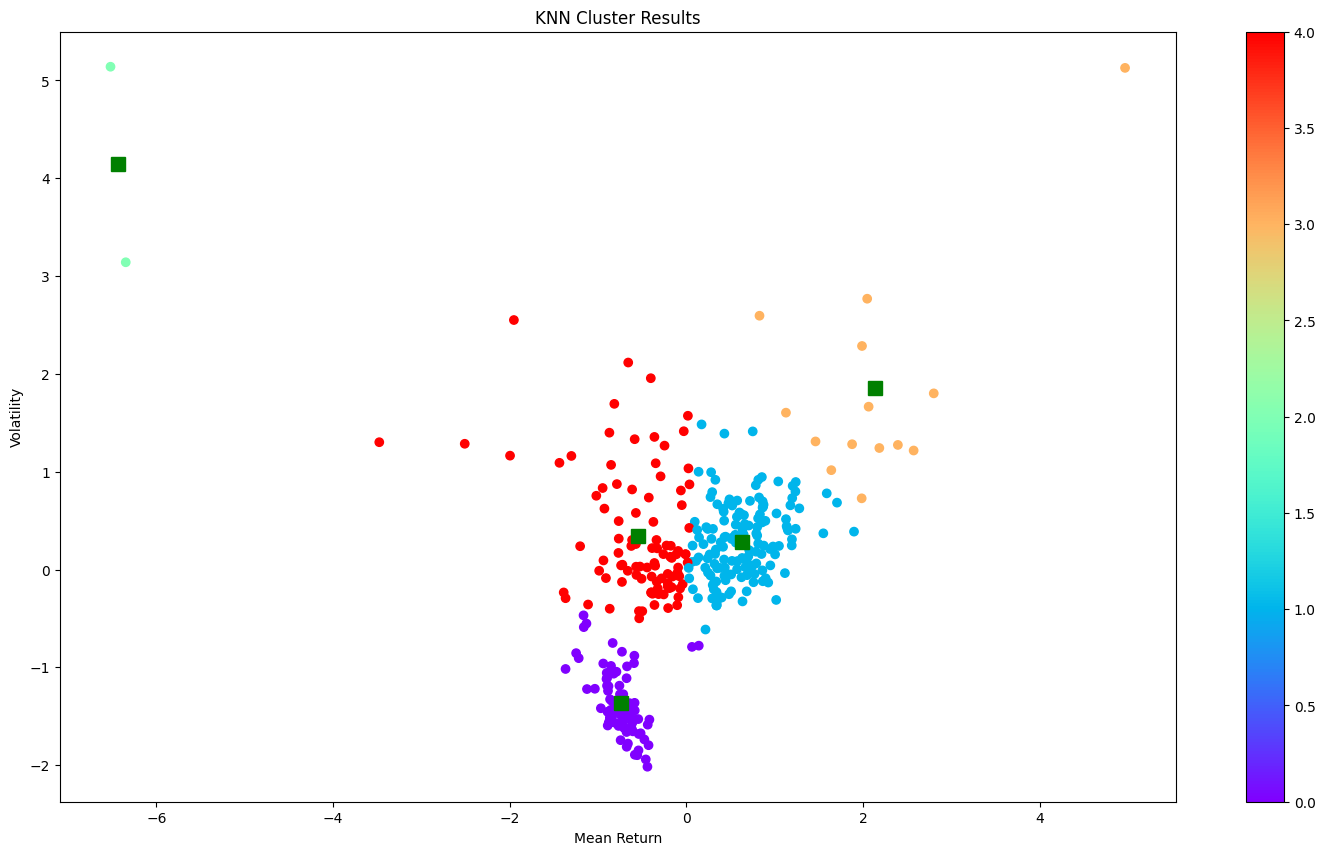

In [80]:
# Obtain the centroids of the clusters from the trained KMeans model.
centroids = k_means.cluster_centers_

# Create a figure to host the plot, with size 18x10.
fig = plt.figure(figsize=(18,10))

# Add a subplot to the figure.
Graphic = fig.add_subplot(111)

# Scatter plot of the data, colored by cluster label.
scatter = Graphic.scatter(x.iloc[:,0], x.iloc[:,1] , c = k_means.labels_, cmap="rainbow" , label=x.index)

# Set the title and labels for the axes of the plot.
Graphic.set_title("KNN Cluster Results")
Graphic.set_xlabel("Mean Return")
Graphic.set_ylabel("Volatility")

# Display a color bar to illustrate which color corresponds to which cluster.
plt.colorbar(scatter)

# Plot the centroids of each cluster as green squares.
plt.plot(centroids[:,0] , centroids[:,1] , "sg" , markersize = 10)
plt.show


In [81]:
# Return Series
clustered_series = pd.Series(index=x.index , data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=x.index , data=k_means.labels_.flatten())

# Remove outliers, denoted by -1, from the series
clustered_series = clustered_series[clustered_series != -1]


clustered_series[:15]

AADR    4
AAXJ    4
ACWI    1
ACWX    4
AGNG    1
AGZD    0
AIA     4
AIQ     1
AIRR    3
ALTY    4
ANGL    0
ASET    4
BBH     1
BFIT    4
BGRN    0
dtype: int32

Text(0.5, 0, 'Cluster')

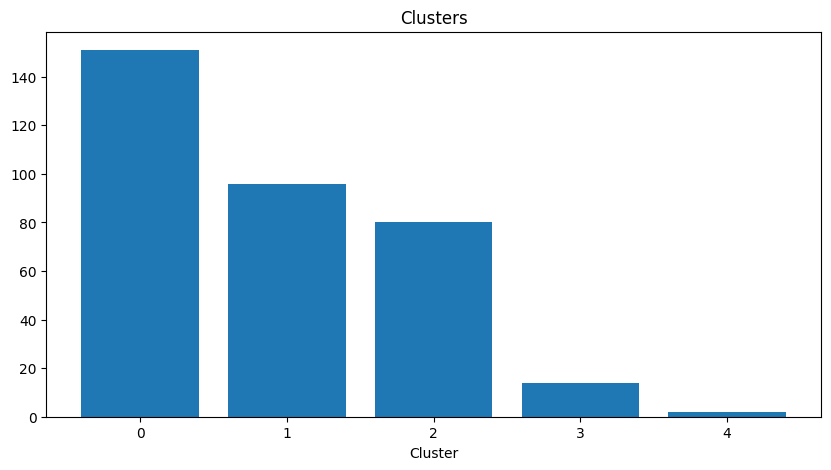

In [82]:
# view number by cluser
plt.figure(figsize=(10,5))

# Generate a bar chart. X-axis is the range of the number of unique clusters. Y-axis is the count of items in each cluster.
plt.bar(range(len(clustered_series.value_counts())) , clustered_series.value_counts())

# Labels
plt.title("Clusters")
plt.xlabel("Cluster")

In [83]:
# Remove Clusters if preferred
clusters_clean = clustered_series[clustered_series < 3]

print(f"Current Clusters: {len(clustered_series)}")
print(f"Cleaned Clusters: {len(clusters_clean)}")

Current Clusters: 343
Cleaned Clusters: 233


# FIND Cointergrated Stock Pairs (linear-cointergration)
- OLS regression

In [84]:
def calc_cointergration(series_1 , series_2):
    # Initialize flag
    coint_flag = 0
    
    # Perform the Augmented Dickey-Fuller test to check for stationarity
    coint_res = coint(series_1 , series_2)
    
    # Extract t-statistic, p-value and critical values from the test results
    count_t = coint_res[0]
    p_value = coint_res[1]
    critical_val = coint_res[2][1]
    
    # Perform Ordinary Least Squares (OLS) regression to find the hedge ratio
    model = sm.OLS(series_1,series_2).fit()
    hedge_ratio = model.params[0]
    
    # If p-value is less than 0.05 (5% significance level) and t-statistic is less than critical value
    # it means the two series are cointegrated and we set the flag to 1
    coint_flag = 1 if p_value < 0.05 and count_t < critical_val else 0

    return coint_flag , hedge_ratio


- goes through a list of asset pairs
- checks if they belong to the same cluster
- if they are not the same asset. Then, it checks if these pairs of assets are cointegrated
    - meaning they move together over time, and appends the cointegrated pairs to a list.

In [85]:
# Initialize two lists: one for storing tested asset pairs, another for storing cointegrated asset pairs.
tested_pairs = []
cointergrated_pairs = []


if not load_coint_pairs:


    # FIND ALL COINTERGRATIONS
    for base_asset in clusters_clean.index:
        
        # BASE CLUSTER NUMBER
        base_label = clusters_clean[base_asset]

        # COMPARE AGAINST EVERY OTHER TICKER
        for compare_asset in clusters_clean.index:
            
            # COMPARISON CLUSTER NUMBER
            compare_label = clusters_clean[compare_asset]

            # CREATE PAIR STRING FOR REFERENCE & SORT
            test_pair = base_asset + compare_asset
            test_pair = "".join(sorted(test_pair))
            
            # CHECK IF TESTED ALREADY
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)

            # CHECK IF BELONG TO SAME CLUSTER
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                
                # FETCH THEIR DATA
                series_1 = df[base_asset].values.astype(float)
                series_2 = df[compare_asset].values.astype(float)
                
                # FIND OUT IF COINTERGRATED OR NOT
                coint_flag , _ = calc_cointergration(series_1,series_2)
                
                if coint_flag == 1:
                    # Add this pair of assets to the list of cointegrated pairs.
                    cointergrated_pairs.append({
                        "base_asset":base_asset,
                        "compare_asset":compare_asset,
                        "label":base_label
                    })

                    print(f"{test_pair.strip()}\t | {_} | {base_label}" )


    df_coint = pd.DataFrame(cointergrated_pairs).sort_values(by="label")
    df_coint.to_csv(filename_co_integration)

In [86]:
# READ FILE
df_coint = pd.read_csv(filename_co_integration).iloc[:, 1:]

df_coint

,base_asset,compare_asset,label
0,VTC,VWOB,0
1,LMBS,SHV,0
2,LMBS,PLW,0
3,FTSM,MFLX,0
4,FTSM,LMBS,0
...,...,...,...
1180,FAB,HERD,1
1181,FAD,FTXR,1
1182,CARZ,PTF,2
1183,CARZ,PSCD,2


# TSNE DATA

In [87]:
# get unique cointergrated assets
coin_assets = [df_coint["base_asset"].values]
coin_assets.append(df_coint["compare_asset"].values)
coin_unique_assets = np.unique(coin_assets)

coin_unique_assets

array(['ACWI', 'AGNG', 'AGZD', 'AIQ', 'ANGL', 'BBH', 'BGRN', 'BJK', 'BND',
       'BNDW', 'BNDX', 'BSCN', 'BSCO', 'BSCP', 'BSCQ', 'BSCR', 'BSCS',
       'BSCT', 'BSJN', 'BSJO', 'BSJP', 'BSJQ', 'BSJR', 'BSMN', 'BSMO',
       'BSMP', 'BSMQ', 'BSMR', 'BSMS', 'BSMT', 'BTEC', 'BUG', 'CACG',
       'CARZ', 'CATH', 'CDC', 'CDL', 'CFA', 'CIBR', 'CLRG', 'CSA', 'CSB',
       'CSF', 'CSML', 'DALI', 'DDIV', 'DGRS', 'DGRW', 'DVLU', 'DVOL',
       'DVY', 'DWAS', 'DWAW', 'DWMC', 'DWUS', 'DXGE', 'EMB', 'EMCB',
       'EQRR', 'ESGU', 'FAB', 'FAD', 'FALN', 'FCAL', 'FDNI', 'FDTS',
       'FEMB', 'FEX', 'FIXD', 'FMB', 'FMHI', 'FNK', 'FNX', 'FNY', 'FSZ',
       'FTA', 'FTAG', 'FTC', 'FTCS', 'FTGC', 'FTQI', 'FTRI', 'FTSL',
       'FTSM', 'FTXG', 'FTXH', 'FTXL', 'FTXR', 'FV', 'FVC', 'FYC', 'FYT',
       'FYX', 'GNMA', 'HERD', 'HEWG', 'HISF', 'HLAL', 'HNDL', 'HYLS',
       'HYXF', 'HYZD', 'IEF', 'IEI', 'IGIB', 'IGOV', 'IGSB', 'IJT',
       'IMCV', 'INDY', 'ISHG', 'ISHP', 'ISTB', 'IUS', 'IUSB', 'IUSG',
       

In [88]:
# Update df_TSNE to contain only the rows with cointergrated assets and their returns and volitility

df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coin_unique_assets)]

df_TSNE

,Returns,Volitility
ACWI,0.338223,-0.122491
AGNG,0.293370,-0.295897
AGZD,-0.705164,-1.619825
AIQ,1.237537,0.416306
ANGL,-0.588525,-0.881308
...,...,...
VWOB,-1.218508,-0.906423
WINC,-0.716086,-1.520005
WOOD,0.242765,0.414491
XT,0.631349,0.118019


In [89]:
# Apply t-SNE transformation to df_TSNE with specific parameters
x_tsne = TSNE(learning_rate=30, perplexity=5,random_state=42, n_jobs=-1).fit_transform(df_TSNE)

x_tsne

array([[  0.51206803, -26.584814  ],
       [ -4.7900257 , -33.923904  ],
       [-47.46813   ,  -2.8752325 ],
       [ 50.01064   ,  -0.33209053],
       [-22.382671  ,  36.984455  ],
       [  3.7064807 ,  -8.494855  ],
       [-40.96044   ,  16.779297  ],
       [ 15.215869  ,  22.904459  ],
       [-34.062412  ,  20.771093  ],
       [-40.8902    ,  15.7916355 ],
       [-42.148045  ,  16.843775  ],
       [-40.49344   , -10.147534  ],
       [-39.71809   ,  -5.476558  ],
       [-41.399086  ,  -4.5848627 ],
       [-36.262783  ,   1.5641139 ],
       [-34.268368  ,   1.9856547 ],
       [-24.70684   ,  27.622002  ],
       [-24.194138  ,  29.038094  ],
       [-23.727589  ,  28.515154  ],
       [-23.183353  ,  30.50929   ],
       [-22.335732  ,  32.858734  ],
       [-16.464632  ,  36.988316  ],
       [-15.261434  ,  35.909424  ],
       [-47.86845   , -13.471223  ],
       [-46.95194   , -12.735654  ],
       [-45.58145   , -11.585846  ],
       [-40.414825  ,  -4.3708596 ],
 

# Display TNSE
- this code is creating a map, where each point is an asset (stock). Assets that behave similarly are shown closer together. Lines between points mean those two assets have been found to move together based on a certain statistical test. The different colors represent different groups of assets that are found to be similar. The goal is to visualize how different assets relate to each other.

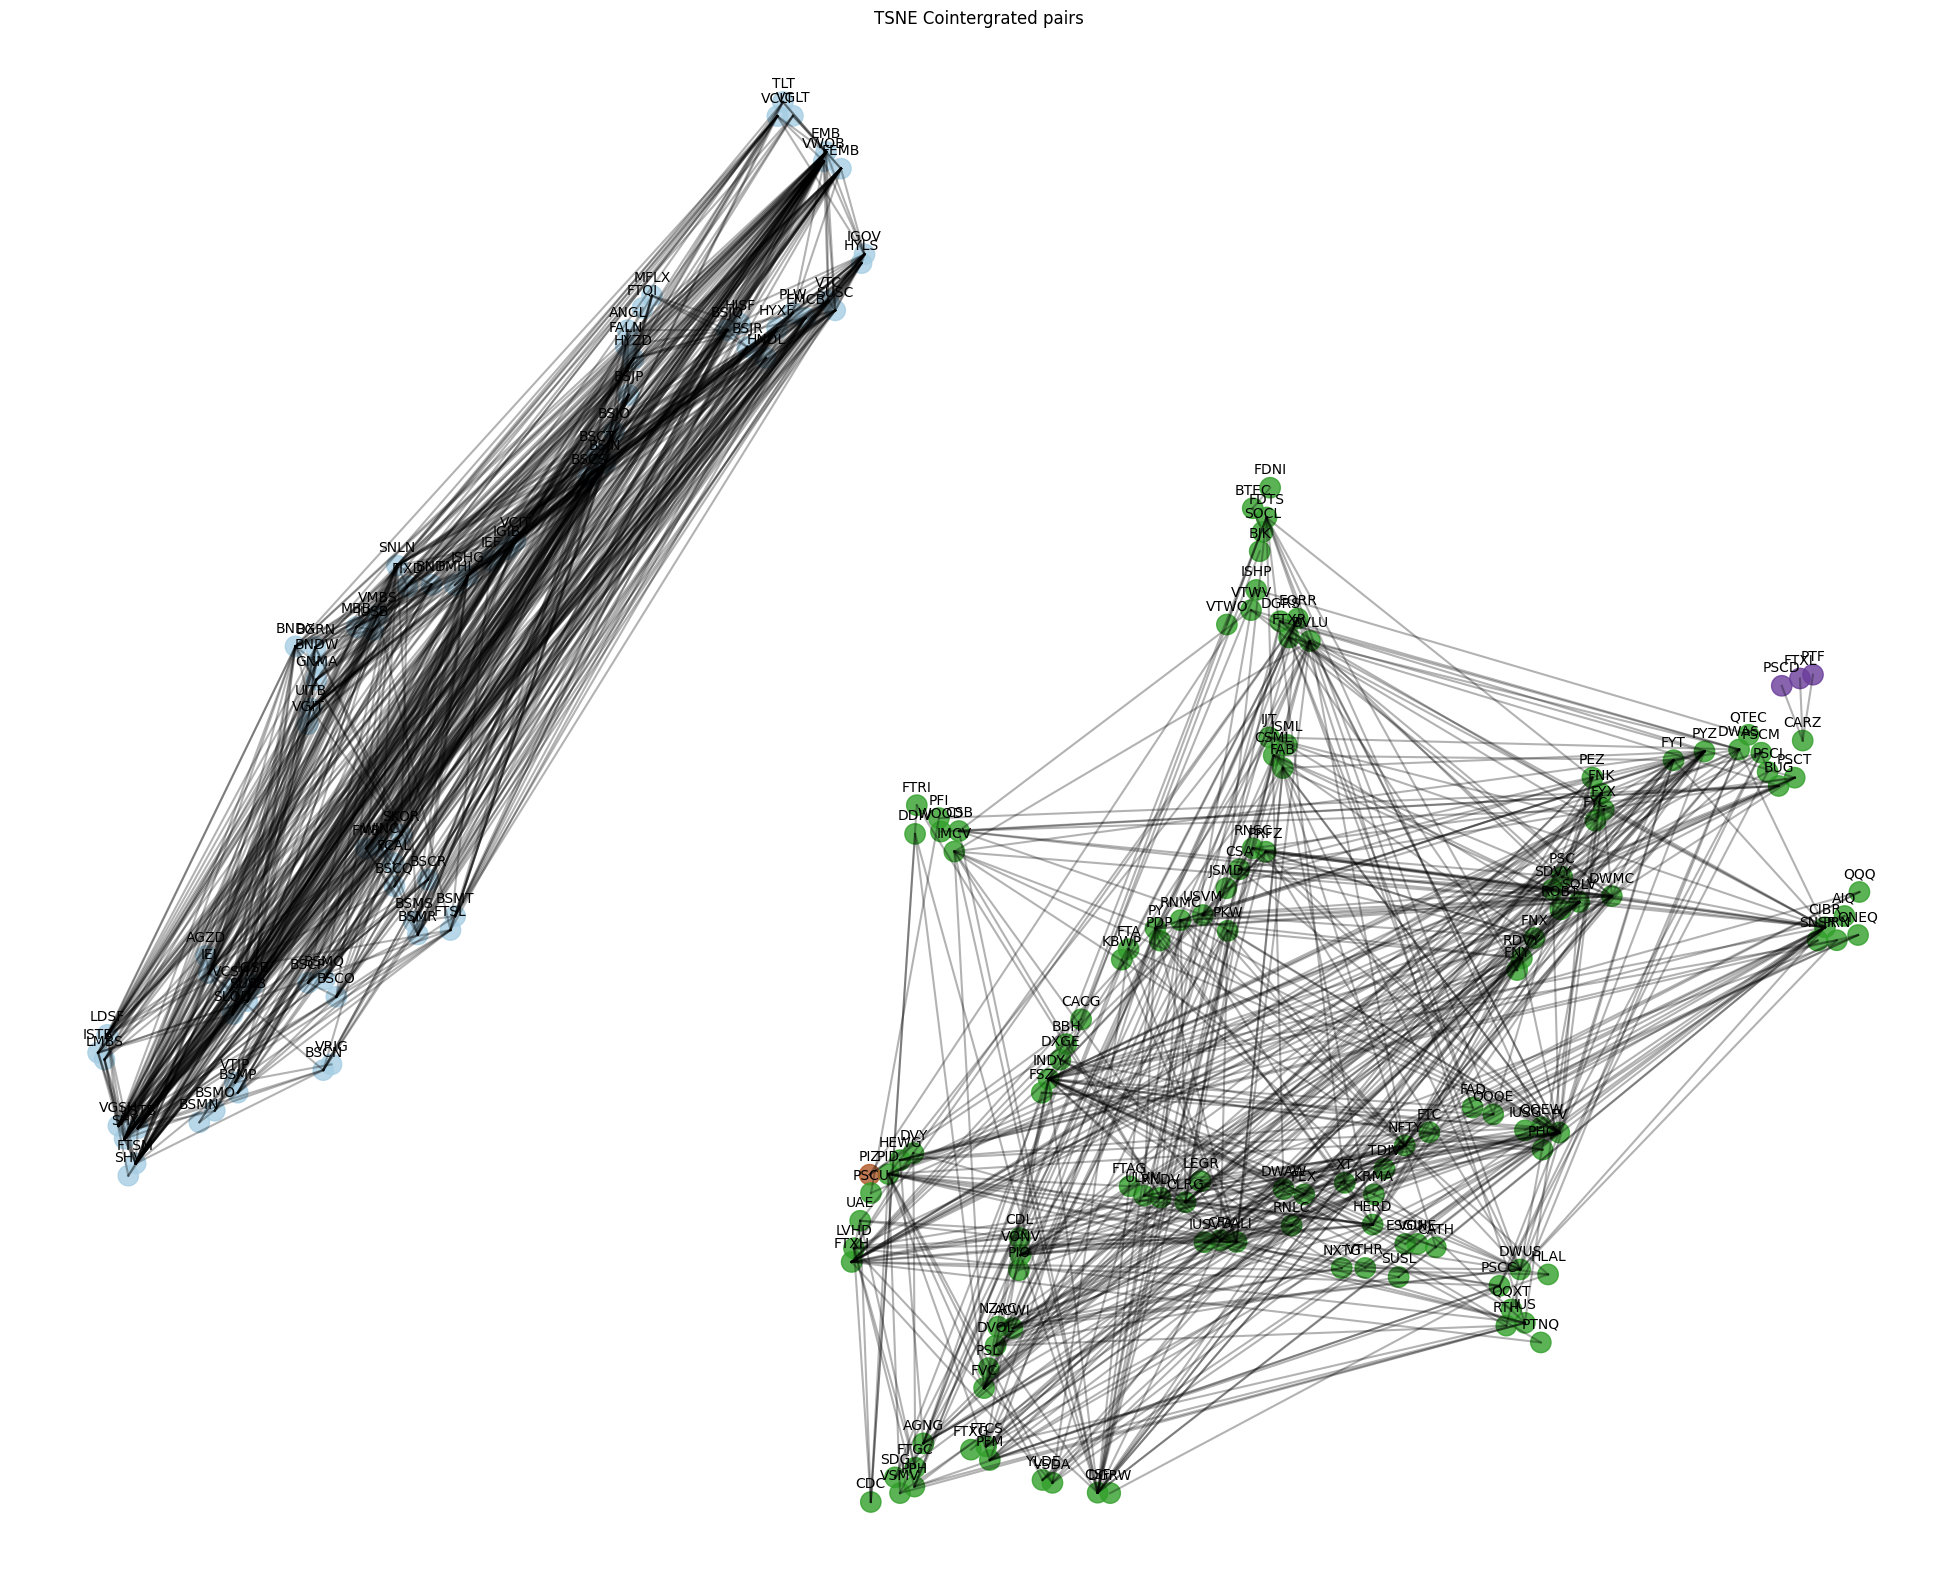

In [90]:
# Get series of clustered pairs
in_pairs_series = clustered_series.loc[coin_unique_assets]

# setup graphic figure
plt.figure(1,figsize=(25,20))
plt.clf()
plt.axis("off")


# Draw line for each pair in df_coint
for index , pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1 , y1 = x_tsne[loc1, :]

    ticker2 = pair[1]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2 , y2 = x_tsne[loc2, :]
    plt.plot([x1,x2] , [y1,y2] , "k-" , alpha=0.3)


# Scatter plot with transformed data and color based on in_pairs_series
plt.scatter(x_tsne[:, 0] , x_tsne[: , 1] , s=215 , alpha=0.8 , c=in_pairs_series.values, cmap=cm.Paired )
plt.title("TSNE Cointergrated pairs")


# Add annotations for each point on the plot
for _x , _y , name in zip(x_tsne[:, 0] , x_tsne[:, 1] , df_TSNE.index):
    label = name
    plt.annotate(label , (_x,_y) , textcoords="offset points" , xytext=(0,10) , ha="center")

# final display
plt.show()

# Review a Pair's Price

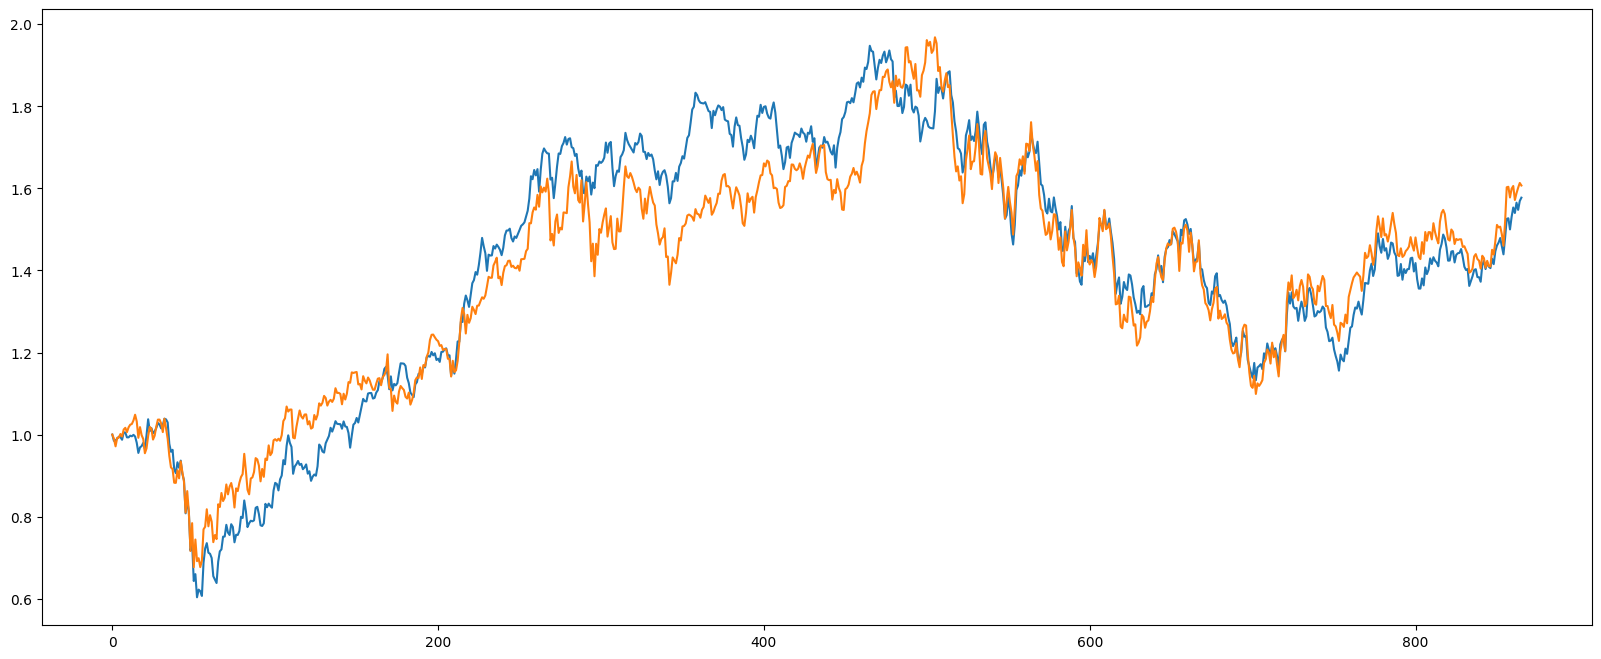

In [91]:
# Plot price comparison for any given asset
asset_1 = "CARZ"
asset_2 = "FTXL"

asset_1_values =  df[asset_1].values / df[asset_1].iloc[0].item()
asset_2_values = df[asset_2].values / df[asset_2].iloc[0].item()

plt.figure( 1 , figsize=(20,8))
plt.plot(asset_1_values)
plt.plot(asset_2_values)
plt.show()





# 0	VTC	VWOB	0
# 1	LMBS	SHV	0
# 2	LMBS	PLW	0
# 3	FTSM	MFLX	0
# 4	FTSM	LMBS	0
# ...	...	...	...
# 1180	FAB	HERD	1
# 1181	FAD	FTXR	1
# 1182	CARZ	PTF	2
# 1183	CARZ	PSCD	2
# 1184	CARZ	FTXL	

# Review a Pair's Spread
- STOCK1 - STOCK2 * hedge ratio
- you want it to be as close to zero as possible

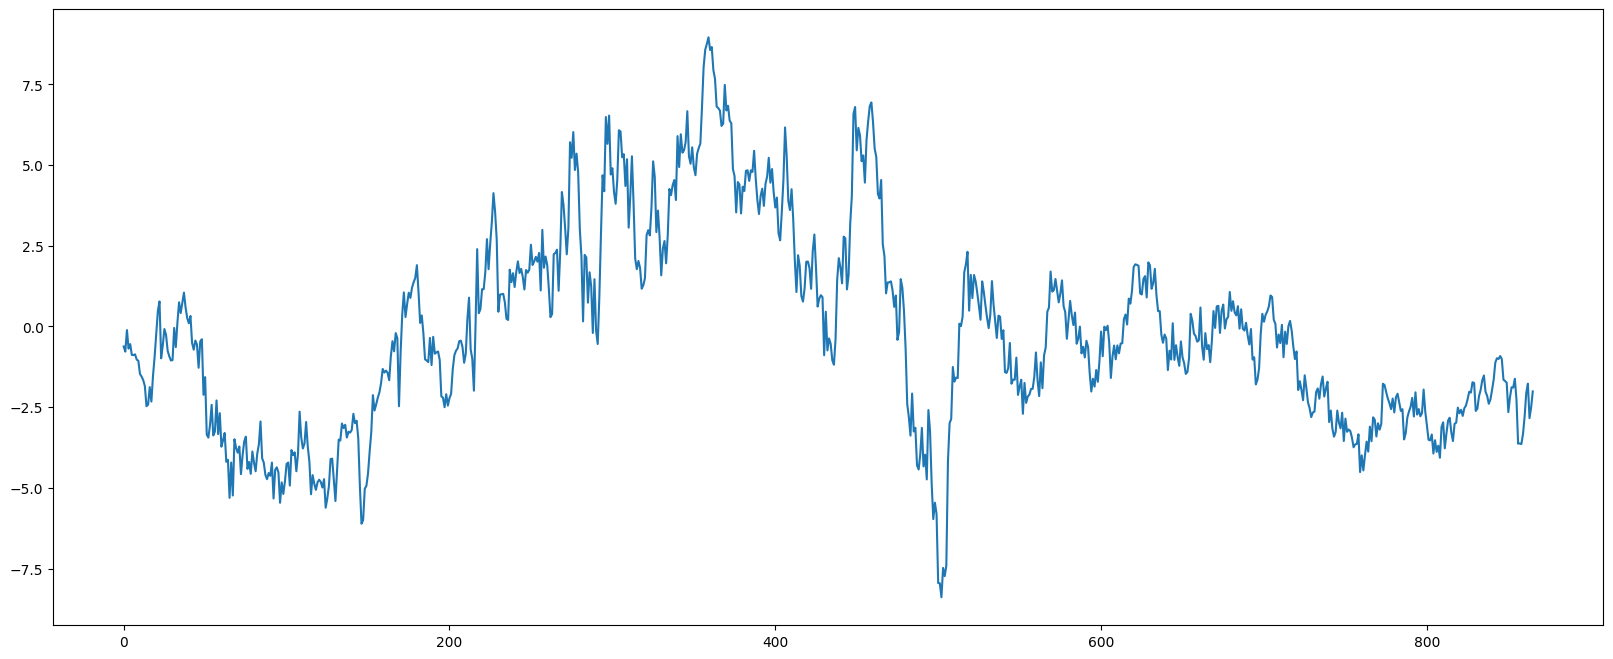

In [92]:
# Plot the spread
# STOCK1 - STOCK2 * hedge ratio


series_1 = df[asset_1].values.astype(float)
series_2 = df[asset_2].values.astype(float)
coint_flag , hedge_ratio = calc_cointergration(series_1 , series_2)


spread = series_1 - (hedge_ratio * series_2)
plt.figure(1 , figsize=(20,8))
plt.plot(spread)
plt.show()

# Z Score
- how tight the band relating these two stocks is getting

In [93]:
# z-score
window = 100 
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False,window=window).mean()
std = spread_series.rolling(center=False,window=window).std()
x = spread_series.rolling(center=False,window=1).mean()


z_score = (x - mean ) / std

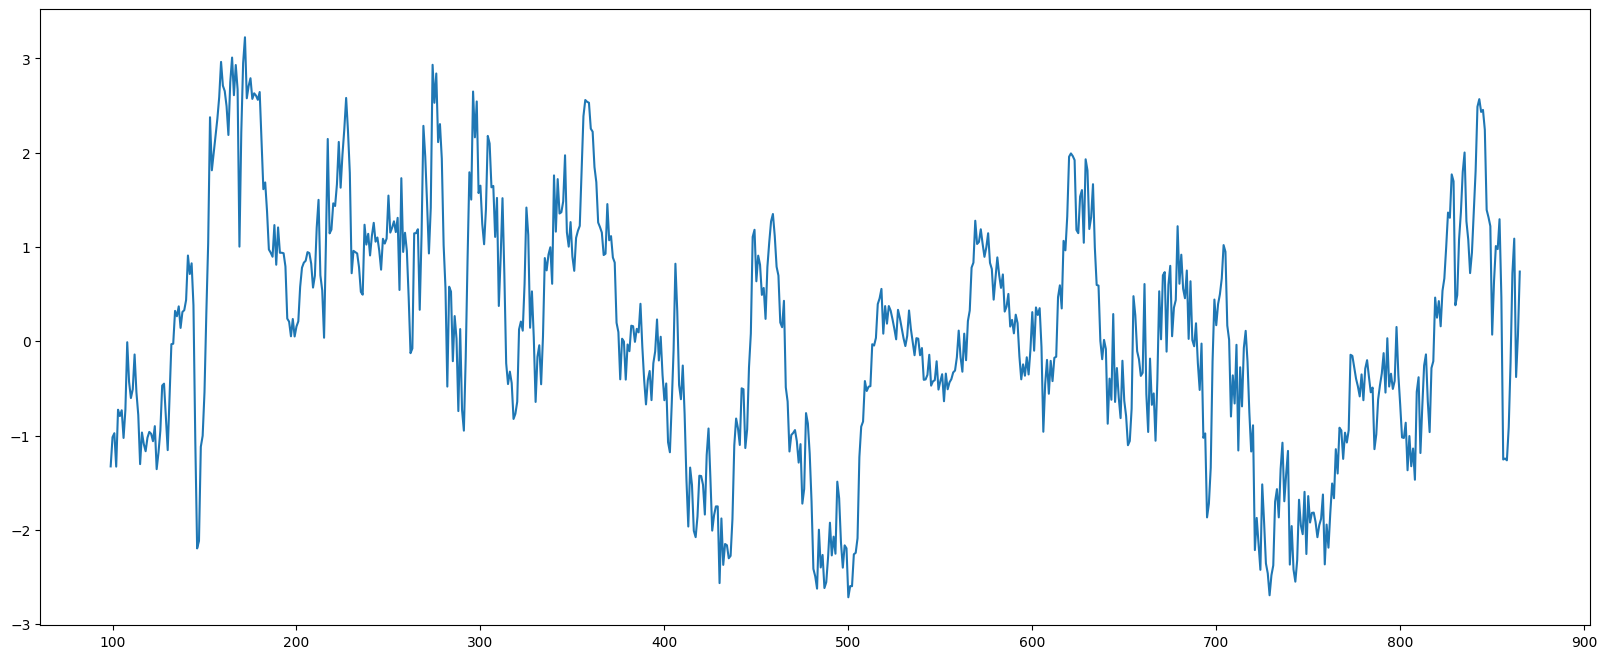

In [94]:
# Display z-score
plt.figure(1 , figsize=(20,8))
plt.plot(z_score)
plt.show()